In [1]:
%load_ext autoreload
%autoreload 2
import torch
from Dreamers.models.transformers.blocks import Attention

In [2]:
n_dim = 128
n_heads = 8
attention = Attention(n_dim, n_heads, qk_norm=True)
x = torch.rand(32, 16, n_dim)
Y = attention(x, x, x)
Y.shape

torch.Size([32, 16, 128])

In [3]:
attention.state_dict()['W_k.weight']

tensor([[ 0.0249,  0.0366, -0.0868,  ...,  0.0792,  0.0448, -0.0853],
        [ 0.0510,  0.0513, -0.0485,  ...,  0.0464,  0.0621, -0.0281],
        [ 0.0540, -0.0060, -0.0370,  ..., -0.0435, -0.0681,  0.0779],
        ...,
        [ 0.0648, -0.0523,  0.0782,  ...,  0.0633,  0.0312, -0.0283],
        [ 0.0467,  0.0178,  0.0273,  ...,  0.0400, -0.0795, -0.0339],
        [-0.0047,  0.0435, -0.0023,  ..., -0.0591,  0.0187,  0.0433]])

In [113]:
from Dreamers.models.transformers.blocks import RopeEmbedding
T = 2047
D = 4
rope = RopeEmbedding(D, 2048)

In [114]:
import torch

q = torch.zeros(2, 4, T, D)
k = torch.zeros(2, 4, T, D)

q[:, :, :, -4:] = torch.tensor([[1., 0., 0., 1.]])
k[:, :, :, -4:] = torch.tensor([[1., 0., 0., 1.]])
rq, rk = rope(q, k)

(-1.0, 1.0)

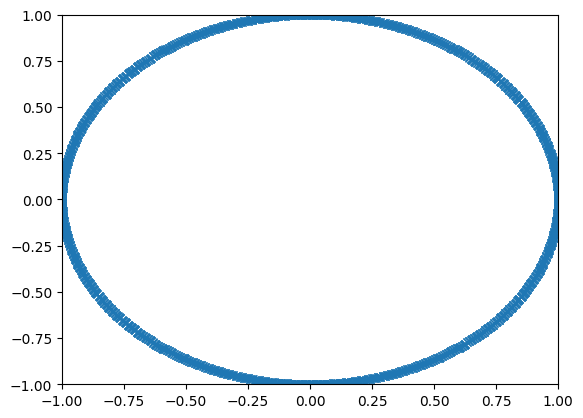

In [103]:
q_odd, q_even = q[..., ::2], q[..., 1::2]
qJ = torch.stack([-q_even, q_odd], dim=-1).reshape_as(q)

q_rot = (q * rope.cos_emb[...,:T,:]) + (qJ * rope.sin_emb[...,:T,:])
plt.plot(q_rot[0,0,:,-4], q_rot[0,0,:,-3], 'x')
# plt.plot(q_rot[0,0,:512,-2], q_rot[0,0,:512,-1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [ ]:
from Dreamers.models.transformers.blocks import RopeEmbedding
from Dreamers.models.transformers.blocks import MultiHeadAttention

n_dim = 128
n_heads = 8
rope = RopeEmbedding(n_dim//n_heads, 2048)
attention = MultiHeadAttention(n_dim, n_heads, rope=rope)
x = torch.rand(32, 16, n_dim)
Y, A = attention(x, x, x)

In [6]:
dim = 2
ndim = 5 # B, D1, D2, D3, D
range(1, dim), dim, range(dim+1, ndim)

(range(1, 2), 2, range(3, 5))

In [7]:
import torch
q = torch.randn(4, 32, 64, 128, 100, dtype=torch.float32)
k = 2

In [12]:

dims = list(q.shape)
B = dims[0]
D = dims[-1]
T_k = dims[k]
flattened_q = q.transpose(k, -2).contiguous().view(-1, T_k, D)

In [24]:
reconstructed_q = flattened_q.view((dims[:k]+dims[k+1:-1]+[dims[k], D])).transpose(k, -2).contiguous()

In [29]:
dim=3
dims_q = list(q.shape)
D = dims_q[-1]
Tq_k = dims_q[dim]
reordered_q = q.transpose(dim, -2).contiguous().view(-1, Tq_k, D)
q - reordered_q.view((dims_q[:dim]+dims_q[dim+1:-1]+[dims_q[dim], D])).transpose(dim, -2).contiguous()

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           

In [46]:
import time

def make_tokenizer_encoder_mask(T, N_patch, N_latent, causal=False, device="cpu"):
    """
    Dreamer-4 Tokenizer Encoder attention mask
    Returns mask [S, S] where S = T * (N_patch + N_latent)
    True = allow attention, False = block.
    """

    S_frame = N_patch + N_latent
    S = T * S_frame

    mask = torch.zeros(S, S, dtype=torch.bool, device=device)

    for t_q in range(T):                         # Query frame
        for t_k in range(T):                     # Key frame

            # Temporal constraint
            if causal and t_k > t_q:
                continue  # future frames blocked

            # Token index ranges
            q_patch_start = t_q * S_frame
            q_latent_start = q_patch_start + N_patch

            k_patch_start = t_k * S_frame
            k_latent_start = k_patch_start + N_patch

            # ----- PATCH QUERY -----
            # Patches can attend ONLY to patches of their own frame
            if t_q == t_k:
                mask[q_patch_start : q_latent_start,     # patch_q
                     k_patch_start : k_latent_start] = True  # patch_k

            # ----- LATENT QUERY -----
            # Latents attend to all patches (all frames allowed under time mask)
            mask[q_latent_start : q_latent_start + N_latent,       # latent_q
                 k_patch_start : k_latent_start] = True            # patch_k

            # Latents attend to all latents
            mask[q_latent_start : q_latent_start + N_latent,       # latent_q
                 k_latent_start : k_latent_start + N_latent] = True

    return mask

def make_tokenizer_decoder_mask(T, N_patch, N_latent, causal=True, device="cpu"):
    """
    Dreamer-4 Tokenizer Decoder attention mask
    Returns mask [S, S] where S = T * (N_patch + N_latent)
    True = allow attention, False = block.
    """

    S_frame = N_patch + N_latent
    S = T * S_frame

    mask = torch.zeros(S, S, dtype=torch.bool, device=device)

    for t_q in range(T):                        # Query frame
        for t_k in range(T):                    # Key frame

            # Temporal constraint
            if causal and t_k > t_q:
                continue

            q_patch_start = t_q * S_frame
            q_latent_start = q_patch_start + N_patch

            k_patch_start = t_k * S_frame
            k_latent_start = k_patch_start + N_patch

            # ----- PATCH QUERY -----
            # Patches attend within same frame
            if t_q == t_k:
                mask[q_patch_start : q_latent_start,       # patch_q
                     k_patch_start : k_latent_start] = True

            # Patches attend to ALL latents (global bottleneck)
            mask[q_patch_start : q_latent_start,           # patch_q
                 k_latent_start : k_latent_start + N_latent] = True

            # ----- LATENT QUERY -----
            # Latents attend ONLY to latent tokens
            mask[q_latent_start : q_latent_start + N_latent,
                 k_latent_start : k_latent_start + N_latent] = True

    return mask

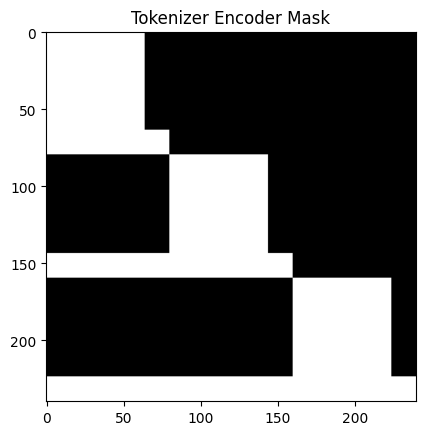

Text(0.5, 1.0, 'Tokenizer Decoder Mask')

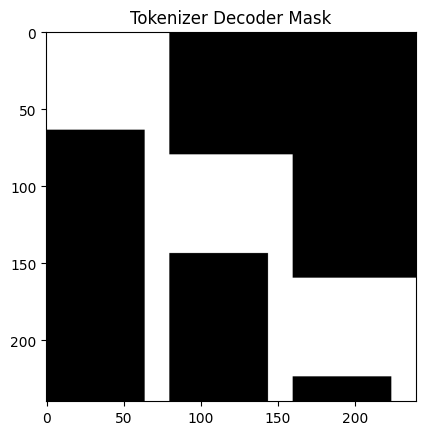

In [48]:
import torch
import matplotlib.pyplot as plt
masks_enc = make_tokenizer_encoder_mask(3, 64, 16, causal=True)
masks_dec = make_tokenizer_decoder_mask(3, 64, 16, causal=True)
plt.imshow(masks_enc.cpu().numpy(), cmap='gray')
plt.title('Tokenizer Encoder Mask')
plt.show()
plt.imshow(masks_dec.cpu().numpy(), cmap='gray')
plt.title('Tokenizer Decoder Mask')

In [ ]:
def make_tokenizer_decoder_mask(T, N_patch, N_latent, causal=False, device="cpu"):
    S = (N_patch+N_latent)*T
    mask = torch.zeros(S, S).to(device).to(torch.bool)
    modalities_starts = torch.arange(T)
    modalities_ends = modalities_starts+N_patch
    tokens_starts = modalities_ends +1
    tokens_ends = modalities_starts+(N_patch+N_latent)


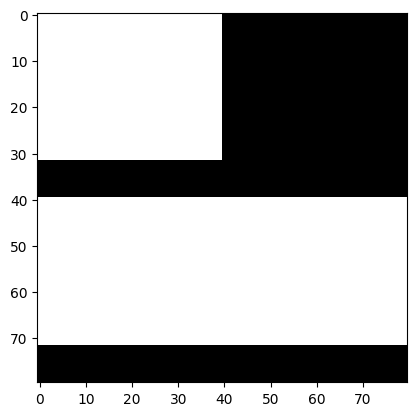

In [89]:
T=2
N_patch=32
N_latent=8
device="cpu"
S = (N_patch+N_latent)*T
mask = torch.zeros(S, S).to(device).to(torch.bool)
modalities_starts = torch.arange(T)*(N_patch+N_latent)
modalities_ends = modalities_starts+N_patch
tokens_starts = modalities_starts + N_patch
tokens_ends = tokens_starts+N_latent
W = N_patch+N_latent
for t1 in range(T):
    for t2 in range(T):
        if t2 <= t1:
            mod_row_start = t1*W
            mod_row_end = mod_row_start + N_patch
            mod_column_start = t2*W
            mod_column_end = mod_column_start+W
            mask[mod_row_start:mod_row_end, mod_column_start:mod_column_end]=True
        
        

plt.imshow(mask, cmap='gray')

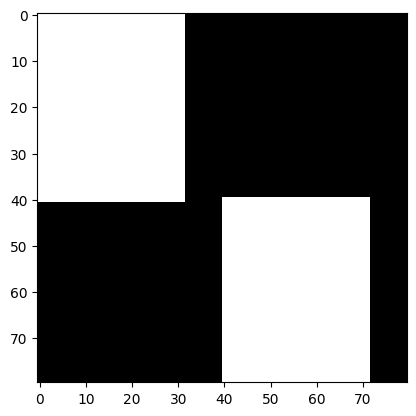

In [ ]:
T=2
N_patch=32
N_latent=8
causal=False 
device="cpu"
S = (N_patch+N_latent)*T
mask = torch.zeros(S, S).to(device).to(torch.bool)
modalities_starts = torch.arange(T)*(N_patch+N_latent)
modalities_ends = modalities_starts+N_patch
tokens_starts = modalities_starts + N_patch
tokens_ends = tokens_starts+N_latent

for t1 in range(T):
    for t2 in range(T):
        
        modality_start = modalities_starts[t]
        modality_end = modalities_ends[t]
        tokens_start = tokens_starts[t]
        tokens_end = tokens_ends[t]
        mask[modality_start:tokens_end+1, modality_start:modality_end] = True 

plt.imshow(mask, cmap='gray')

In [66]:
tokens_starts

tensor([32, 72])

In [58]:
tokens_ends

tensor([40, 72])